In [1]:
from nltk.corpus import stopwords
import re

from termcolor import colored
import math

import nltk

from nltk import bigrams
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

import gensim

nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk import word_tokenize
from operator import itemgetter

import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from gensim.models.ldamodel import LdaModel
from collections import Counter

import numpy as np
import pandas as pd

import operator

[nltk_data] Downloading package wordnet to /home/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import warnings


def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
from nltk.corpus import stopwords
import re

from termcolor import colored
import math

import nltk

from nltk import bigrams
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

import gensim

nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk import word_tokenize


import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from gensim.models.ldamodel import LdaModel

import calendar

[nltk_data] Downloading package wordnet to /home/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
np.random.seed(42)

In [5]:
os.chdir(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/"
)

# Part 1

## Data Preparation

In [6]:
df_customer_Churn = pd.read_csv("Data/Daily_Churned_customers_JET.csv")

df_input_accounts = pd.read_csv("Data/input_accounts_21_10_2022.csv")

df_tweets = pd.read_csv("Data/tweets-2022-10-21_justeattakeaway.csv")

In [7]:
df_tweets = pd.merge(
    left=df_tweets,
    right=df_input_accounts,
    left_on="user_id",
    right_on="user_id",
    how="left",
)
df_input_accounts = None

In [8]:
# add a simple dummy for JET companies or not
df_tweets["JET"] = 0
df_tweets.loc[
    df_tweets.full_name.isin(["thuisbezorgd", "Just Eat Takeaway.com", "Just Eat UK"]),
    "JET",
] = 1

# remove all non english tweets
df_tweets = df_tweets[df_tweets.lang == "en"]

df_tweets.reset_index(inplace=True, drop=True)

In [9]:
# delta chrun
df_customer_Churn["d_churn"] = (
    df_customer_Churn["Churned customers"].shift(1)
    - df_customer_Churn["Churned customers"]
)

In [10]:
# time question
df_tweets["created_at"] = pd.to_datetime(df_tweets.created_at)
df_tweets["year"] = pd.DatetimeIndex(df_tweets.created_at).year
df_tweets["month"] = pd.DatetimeIndex(df_tweets.created_at).month
df_tweets["day"] = pd.DatetimeIndex(df_tweets.created_at).day
df_tweets["hour"] = pd.DatetimeIndex(df_tweets.created_at).hour


df_tweets["Month_t"] = df_tweets["month"].apply(
    lambda x: calendar.month_abbr[x]
)
# weekday
df_tweets["weekday"] = df_tweets.created_at.dt.strftime("%A")

# summer/Winter/ quarters
df_tweets["season_quarters"] = pd.DatetimeIndex(df_tweets.created_at).quarter

# a simple trick to create "seasons"
df_tweets["season"] = df_tweets.month % 12 // 3 + 1

# Part 2

## Lanugage Preprocessing and some modeling

In [11]:
additional = [
    "rt",
    "rts",
    "retweet",
    "please",
    "ha",
    "w",
    "dm",
    "amp",
]  # we'll store additional stopwords here
swords = set().union(stopwords.words("english"), additional)

# replace all signs and stopwords in tweets and tokenize tweets (tokenization means splitting up a larger body of text into pieces such as words, keywords, phrases, symbols and other elements called tokens; in our case we can split the tweets into words)
df_tweets.drop_duplicates(subset="text", inplace=True)
df_tweets["text"] = df_tweets["text"].str.lower()

df_tweets["processed_text"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
    .apply(lambda x: [i for i in x.split() if not i in swords])
)

df_tweets["simple_preprocessing"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
)

/tmp/ipykernel_85293/4108272791.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets["text"]
/tmp/ipykernel_85293/4108272791.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets["text"]


## Only use JET

In [12]:
# only use JET tweets
df_tweets_jet = df_tweets[df_tweets.JET == 1]

## Only NOT in reply to user but only offerings by the customers 

In [13]:
df_tweets_jet = df_tweets_jet[df_tweets_jet.in_reply_to_user_id.isna()]

## Lemmatize

In [14]:
wnl = WordNetLemmatizer()


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        regex_num_ponctuation = "(\d+)|([^\w\s])"
        regex_little_words = r"(\b\w{1,2}\b)"
        regex_smiley = "(@[a-z0-9]+)\w+"
        regex_signs = "(http\S+)"
        regex_tweet_spec = "([^0-9a-z \t])"
        regex_https = " +"
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if not re.search(regex_num_ponctuation, t)
            and not re.search(regex_smiley, t)
            and not re.search(regex_signs, t)
            and not re.search(regex_tweet_spec, t)
            and not re.search(regex_little_words, t)
            and not re.search(regex_https, t)
        ]

In [15]:
swords = set().union(stopwords.words("english"), additional)

count = CountVectorizer(
    stop_words=swords,
    tokenizer=LemmaTokenizer(),
    ngram_range=(1, 2),  # will create a vocabulary with 1-gram and 2-grams
    min_df=2,
    max_df=0.9,
    max_features=2000,
    lowercase=True,
    strip_accents="unicode",
)

matrix = count.fit_transform(df_tweets_jet.simple_preprocessing)


results = pd.DataFrame(matrix.toarray(), columns=count.get_feature_names())

/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  warnings.warn(
/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2 

# describe JET's 


## 2.1: for this question only focus on what the company did and only their tweets and NOT IN REPLY!


2.1 What are the main topics the company tweets about? What are the most used words / hashtags / bigrams (trigrams)? How often and in which moments of time does the platform post tweets most often?* (1 slide)

*Before you analyze the texts of tweets, please, preprocess the texts of tweets. You can find the list of simple preprocessing steps below, but you may also do any more sophisticated preprocessing (upon your choice).


for 2.1: 
- Only what did the company tweet about
- what topics did they tweet about?


In [16]:
corpus = gensim.matutils.Sparse2Corpus(matrix, documents_columns=False)
id_map = dict((v, k) for k, v in count.vocabulary_.items())


K = 12
lda = LdaModel(
    corpus=corpus,
    id2word=id_map,
    num_topics=K,
    alpha="auto",
    eta="auto",
    iterations=100,
    passes=20,
    eval_every=None,
    random_state=42,
    per_word_topics=True,
)

#### 2. 1 what topics did they tweet about?

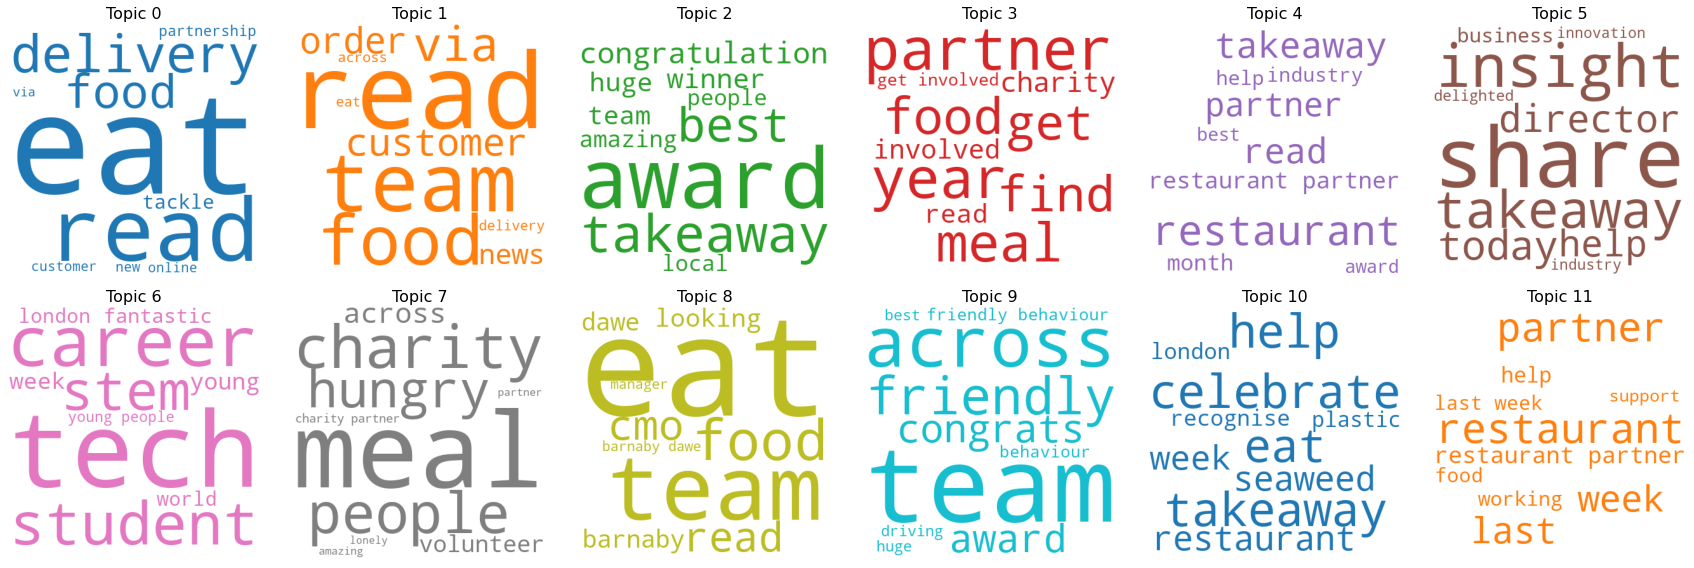

In [17]:
nb_columns = 6
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=20,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)


fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title("Topic " + str(i), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [18]:
names = [
    "CRM & Partner Management",
    "External Celebration",
    "Novelties & Business Innovations",
    "Human Captial Generation",
    "Charity",
    "Plastic & SCG",
]

topic_names = {i: v for i, v in enumerate(names)}

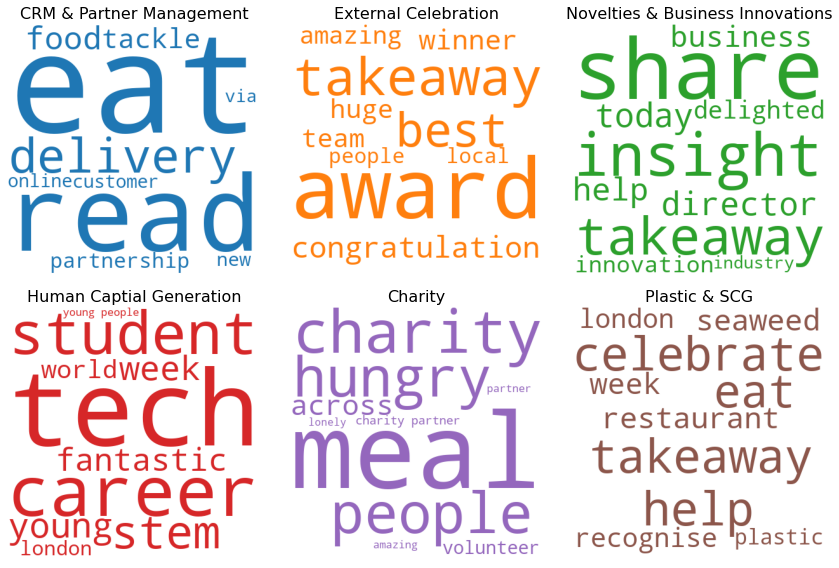

In [19]:
####################################
K = 12
topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)


topics = operator.itemgetter(0, 2, 5, 6, 7, 10)(topics)

nb_columns = 3
K = len(topics)
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=15,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)


fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title(str(names[i]), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [20]:
# this will help to reassign topics
by_get_document_topics = list(map(lda.get_document_topics, corpus))

# extract topic loadings and topics by document
topic_loadings = []
topic_number = []
for loading in by_get_document_topics:
    t = list(map(itemgetter(1), loading))
    topic_loadings.append(max(t))
    topic_number.append(t.index(max(t)))

In [21]:
df_tweets_jet["topic_number"] = topic_number
df_tweets_jet["topic_loadings"] = topic_loadings

In [22]:
# essentially, if the tweet does not load on a relevant topic such as 0 or 10, it is going to get an unimporatance sticker
df_tweets_jet["relevant_topic_loading"] = 1
df_tweets_jet.loc[
    ~df_tweets_jet.topic_number.isin([0, 2, 5, 6, 7, 10]), "relevant_topic_loading"
] = 0

#### 2. 1 Hashtags, bigrams


In [23]:
# most fequent words and trigrams
# conver the results into a list of lsits
processed_words = {}
for i, r in results.iterrows():
    processed_words[i] = list(r[r != 0].index)

df_tweets_jet["processed_words_lemma"] = processed_words.values()

df_results = pd.DataFrame(results.sum(), columns=["count_words"]).sort_values(
    by="count_words", ascending=False
)


additiona = {}
counter = 0
for i, r in df_results.iterrows():
    additiona[counter] = len(i.split())
    counter += 1

df_results["length"] = additiona.values()

In [24]:
# obtain the bigrams using the basic preprocessing

bigramsearies = pd.Series(
    [
        word
        for sublist in df_tweets_jet.processed_text.dropna()
        .apply(lambda x: [i for i in bigrams(x)])
        .tolist()
        for word in sublist
    ]
).value_counts()

In [25]:
# extract the hashtags
hashtags_df = df_tweets_jet[df_tweets_jet.text.str.contains("#")].text.str.findall(
    r"#.*?(?=\s|$)"
)

# 1. stack the hashtags and count them
hashtags_count = dict(Counter(x for xs in list(hashtags_df.values) for x in set(xs)))

hashtags_count = {
    k: v
    for k, v in sorted(hashtags_count.items(), reverse=True, key=lambda item: item[1])
}

hashtags_df = pd.DataFrame(hashtags_df).rename(columns = {"text": "hashtag"})

df_tweets_jet = pd.merge(
    left=df_tweets_jet, right=hashtags_df, left_index=True, right_index=True, how="left"
)


hashtags_df = (
    df_tweets_jet["text"]
    .apply(lambda x: pd.value_counts(re.findall("(#\w+)", x.lower())))
    .sum(axis=0)
    .to_frame()
    .reset_index()
    .sort_values(by=0, ascending=False)
)
hashtags_df.columns = ["hashtag", "occurences"]

"""

What is notable from the stacked hashtags is that the location tag is obviously frequently used to show the targeted location of the tweet.

However, based on the reasonably large frequency of '#stem': 43,  '#tech': 34, '#womenintech': 25, '#tech.': 12,
 '#foodtech': 12,
 '#plasticfree': 12, '#innovation': 12,  '#tech!': 24,
 --> we can see that 1. JET uses the tweets to find new employees, to futher women in tech and also to promote themselfes as 
 a tech platfrom attracting human capital

--> This also goes hand in hand with the findings from the topic modeling in which tech is a prominent feature in all feaeatures 
"""

"\n\nWhat is notable from the stacked hashtags is that the location tag is obviously frequently used to show the targeted location of the tweet.\n\nHowever, based on the reasonably large frequency of '#stem': 43,  '#tech': 34, '#womenintech': 25, '#tech.': 12,\n '#foodtech': 12,\n '#plasticfree': 12, '#innovation': 12,  '#tech!': 24,\n --> we can see that 1. JET uses the tweets to find new employees, to futher women in tech and also to promote themselfes as \n a tech platfrom attracting human capital\n\n--> This also goes hand in hand with the findings from the topic modeling in which tech is a prominent feature in all feaeatures \n"

In [26]:
# hashtags and bigrams plot
df_bigramsearies = pd.DataFrame.from_dict(
    dict(bigramsearies), orient="index", columns=["Counts_Bigram"]
).reset_index()

In [27]:
df_bigramsearies.rename(columns={"index": "bigrams"}, inplace=True)

df_bigramsearies["bigrams"] = df_bigramsearies["bigrams"].astype(str)

In [28]:
hashtags_df = hashtags_df.reset_index().drop(columns=["index"])

/tmp/ipykernel_85293/3282894672.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
/tmp/ipykernel_85293/3282894672.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(


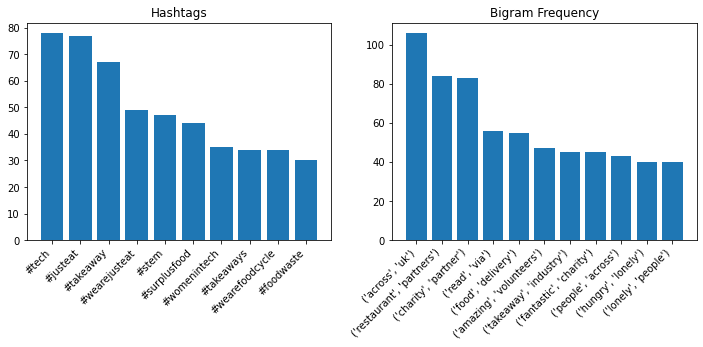

In [29]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.bar(data=hashtags_df.iloc[2:12, :], height="occurences", x="hashtag")
ax1.set_xticklabels(
    labels=hashtags_df.iloc[2:12, :]["hashtag"], rotation=45, ha="right"
)
ax1.set_title("Hashtags")

ax2.bar(data=df_bigramsearies.loc[:10, :], height="Counts_Bigram", x="bigrams")

ax2.set_xticklabels(
    labels=df_bigramsearies.loc[:10, :]["bigrams"], rotation=45, ha="right"
)
ax2.set_title("Bigram Frequency")

plt.show()

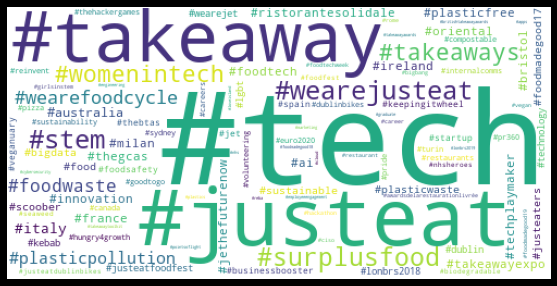

In [30]:
# Create a WordCloud object
wordcloud = WordCloud(
    width=500,
    height=250,
    background_color="white",
    max_words=100,
    contour_width=3,
    contour_color="steelblue",
)


# Generate a word cloud
wordcloud.generate_from_frequencies(
    dict(hashtags_df.iloc[2:, :].set_index("hashtag").occurences)
)

# Visualize the word cloud
wordcloud.to_image()


plt.figure(figsize=(10, 5), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

In [31]:
# df_tweets_jet[df_tweets_jet.processed_words_lemma.str.join("").str.contains("tech")]

#### 2. 1 General Wordclouds

In [32]:
# Join the different processed titles together.
long_string = []
for i in df_tweets_jet.processed_words_lemma:
    long_string.extend(i)


long_string = " ".join(long_string)

In [33]:
# this is not frequency based so better not use it

# # Create a WordCloud object
# wordcloud = WordCloud(
#     width=1600,
#     height=800,
#     background_color="white",
#     max_words=200,
#     contour_width=3,
#     contour_color="steelblue",
# )


# # Generate a word cloud
# wordcloud.generate(str(long_string))

# # Visualize the word cloud
# wordcloud.to_image()


# plt.figure(figsize=(20, 10), facecolor="k")
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

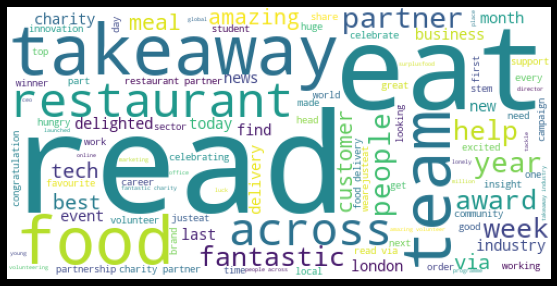

In [34]:
# Create a WordCloud object
wordcloud = WordCloud(
    width=500,
    height=250,
    background_color="white",
    max_words=100,
    contour_width=3,
    contour_color="steelblue",
)


# Generate a word cloud
wordcloud.generate_from_frequencies(dict(df_results.count_words))

# Visualize the word cloud
wordcloud.to_image()


plt.figure(figsize=(10, 5), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")

plt.show()

#### 2. 1 How often does the company tweet per month (beginning or end of month), weekdays

consider wrt when in a month the company tweets the costs of advertising; they might tweeet more during times when there is less to gain from conventional stuff happening







Important: i do assume that the Time Zone issues of London vs other times is fixed and reflected in the original timezone!




"thuisbezorgd", "Just Eat Takeaway.com", "Just Eat UK"

In [35]:
# group by function
def groupby_time(df_, time_col):
    cats = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    df_return = df_.groupby(by=time_col).agg({"tweet_id": "count"}).reset_index()
    return df_return.groupby([time_col]).sum().reindex(cats)

In [36]:
df_plot = groupby_time(df_tweets_jet, "weekday").reset_index()

In [37]:
df_tmp_ = pd.DataFrame(np.arange(1, 25), columns=["hour"])

df_tmp_2 = df_tweets_jet.groupby(by="hour").agg({"tweet_id": "count"}).reset_index()

df_ploth = pd.merge(
    left=df_tmp_, right=df_tmp_2, left_on="hour", right_on="hour", how="left"
).fillna(0)


df_tmp_2, df_tmp_ = None, None

In [38]:
df_tweets_jet_month_weekday = (
    df_tweets_jet.groupby(by=["Month_t", "weekday"])
    .agg({"tweet_id": "count"})
    .reset_index()
)

In [39]:
df_tweets_jet_month_weekday
# convert to month_weekday one column

df_tweets_jet_month_weekday["month_weekday"] = (
    df_tweets_jet_month_weekday.Month_t.astype(str)
    + "-"
    + df_tweets_jet_month_weekday.weekday.astype(str)
)

In [40]:
# trace1 = go.Bar(
#     x=df_plot.weekday,
#     y=df_plot.tweet_id,
#     name="No. of stations",
#     # text=temp_df1.id,
#     textposition="outside",
#     # marker=dict(color=chosen_colors[0]),
# )


# data = [trace1]

# layout = go.Layout(
#     title="Frequency of Tweets",
#     xaxis=dict(title="WeekDay"),
#     yaxis=dict(title="Twee"),
# )

# figure = go.Figure(data=data, layout=layout)

# iplot(figure)

/tmp/ipykernel_85293/1623448624.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=df_plot.weekday, rotation=45, ha="right")


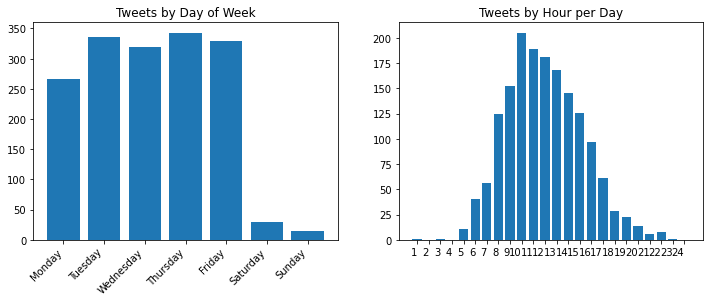

In [41]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.bar(height=df_plot.tweet_id, x=df_plot.weekday)
ax1.set_xticklabels(labels=df_plot.weekday, rotation=45, ha="right")
ax1.set_title("Tweets by Day of Week")

ax2.bar(height=df_ploth.tweet_id, x=df_ploth.hour)
ax2.set_xticks(np.arange(1, 25))
ax2.set_xticklabels(labels=np.arange(1, 25), rotation=0, ha="right")
ax2.set_title("Tweets by Hour per Day")

plt.show()

In [42]:
"""
what is interresting about this plot is that there is almost no planning nad automatiion for the weekend in terms 
of tweets while this seems to be lost potentipoal in free advertising during which people have time to scroll through social media

the problem: there was less indiction regarding the core buisiness and mostly tweets about general things!

"""

'\nwhat is interresting about this plot is that there is almost no planning nad automatiion for the weekend in terms \nof tweets while this seems to be lost potentipoal in free advertising during which people have time to scroll through social media\n\nthe problem: there was less indiction regarding the core buisiness and mostly tweets about general things!\n\n'

## 2.2 Please, compute the sentiment scores for each tweet using nltk (vader) library or any other library of your choice. You may also engineer any additional variables based on computed sentiment scores. How could you describe the platform’s tweets based on their sentiment scores? (1 slide)​



--> Featue engineersing variables
1. Has relevant hashtag True False
2. Sentiment score bins (has sentiment or not)
3. feature engineer the outcome variable
4. Temproal vairable in terms of hour
5. In reply to user yes not
6. Seasonal Variable 
7. topic loadings and topic (only select relevant topics here) (if loads strongly)

### Repeated Preprocessing based on all tweets with replies and not being replies

### and merge the two datasets then later again 

In [43]:
df_tweets_tot = df_tweets[(df_tweets.JET == 1) & ~(df_tweets.in_reply_to_user_id.isna())]

In [44]:
matrix = count.fit_transform(df_tweets_tot.simple_preprocessing)


results = pd.DataFrame(matrix.toarray(), columns=count.get_feature_names())

corpus = gensim.matutils.Sparse2Corpus(matrix, documents_columns=False)
id_map = dict((v, k) for k, v in count.vocabulary_.items())


K = 12
lda = LdaModel(
    corpus=corpus,
    id2word=id_map,
    num_topics=K,
    alpha="auto",
    eta="auto",
    iterations=100,
    passes=20,
    eval_every=None,
    random_state=42,
    per_word_topics=True,
)

/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
# this will help to reassign topics
by_get_document_topics = list(map(lda.get_document_topics, corpus))

# extract topic loadings and topics by document
topic_loadings = []
topic_number = []
for loading in by_get_document_topics:
    t = list(map(itemgetter(1), loading))
    topic_loadings.append(max(t))
    topic_number.append(t.index(max(t)))

df_tweets_tot["topic_number"] = topic_number
df_tweets_tot["topic_loadings"] = topic_loadings


# now just add a 12 to it so that it corresponds
df_tweets_tot["topic_number"] += 12



In [46]:

# most fequent words and trigrams
# conver the results into a list of lsits
processed_words = {}
for i, r in results.iterrows():
    processed_words[i] = list(r[r != 0].index)

df_tweets_tot["processed_words_lemma"] = processed_words.values()

df_results = pd.DataFrame(results.sum(), columns=["count_words"]).sort_values(
    by="count_words", ascending=False
)

In [47]:



additiona = {}
counter = 0
for i, r in df_results.iterrows():
    additiona[counter] = len(i.split())
    counter += 1

df_results["length"] = additiona.values()




bigramsearies = pd.Series(
    [
        word
        for sublist in df_tweets_tot.processed_text.dropna()
        .apply(lambda x: [i for i in bigrams(x)])
        .tolist()
        for word in sublist
    ]
).value_counts()

In [48]:
# extract the hashtags
hashtags_df = df_tweets_tot[df_tweets_tot.text.str.contains("#")].text.str.findall(
    r"#.*?(?=\s|$)"
)

# 1. stack the hashtags and count them
hashtags_count = dict(Counter(x for xs in list(hashtags_df.values) for x in set(xs)))

hashtags_count = {
    k: v
    for k, v in sorted(hashtags_count.items(), reverse=True, key=lambda item: item[1])
}

hashtags_df = pd.DataFrame(hashtags_df).rename(columns = {"text": "hashtag"})

df_tweets_tot = pd.merge(
    left=df_tweets_tot, right=hashtags_df, left_index=True, right_index=True, how="left"
)





In [49]:
df_tweets_tot["relevant_topic_loading"] = 0

# merge 

In [58]:
len(df_tweets_tot) + len(df_tweets_jet)

5601

In [55]:
df_merged = df_tweets_tot.append(df_tweets_jet, ignore_index=True)

/tmp/ipykernel_85293/3676219186.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merged = df_tweets_tot.append(df_tweets_jet, ignore_index=True)


## Sentiment analyis

In [ ]:
import nltk.sentiment.vader as vd
from nltk import download

download("vader_lexicon")

sia = vd.SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize

df_merged["sentiment_score"] = df_merged["processed_words_lemma"].apply(
    lambda x: sum(
        [sia.polarity_scores(i)["compound"] for i in word_tokenize(" ".join(x))]
    )
)
df_merged[["processed_words_lemma", "sentiment_score"]].head(n=10)

# df_tweets_jet["sentiment_score"].apply(
#     lambda x: round(
#         x,
#     )
# ).value_counts()

df_merged["round_sentiment"] = df_merged["sentiment_score"].apply(
    lambda x: round(
        x,
    )
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/angelo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<IPython.core.display.Javascript object>

In [ ]:
import nltk.sentiment.vader as vd
from nltk import download

download("vader_lexicon")

sia = vd.SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize

df_tweets_tot["sentiment_score"] = df_tweets_tot["processed_words_lemma"].apply(
    lambda x: sum(
        [sia.polarity_scores(i)["compound"] for i in word_tokenize(" ".join(x))]
    )
)
df_tweets_tot[["processed_words_lemma", "sentiment_score"]].head(n=10)

# df_tweets_jet["sentiment_score"].apply(
#     lambda x: round(
#         x,
#     )
# ).value_counts()

df_tweets_tot["round_sentiment"] = df_tweets_tot["sentiment_score"].apply(
    lambda x: round(
        x,
    )
)


# create sentiment score for regression eg a dummy
df_tweets_tot["rank_round_sentiment"] = df_tweets_tot["round_sentiment"].rank(
    method="first"
)

df_tweets_tot["quantile_round_sentiment"] = df_tweets_tot[
    "rank_round_sentiment"
].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)

<IPython.core.display.Javascript object>

In [ ]:
df_tweets[df_tweets.JET == 1]

,tweet_id,user_id,text,conversation_id,created_at,fetched_at,in_reply_to_user_id,lang,geo,possibly_sensitive,...,quote_count,retweeted_id,replied_to_id,quoted_id,withheld,user_name,full_name,JET,processed_text,simple_preprocessing
8978,1582597815922221056,272030125,just eat https://t.co/irejqclqk3 q3 2022 tradi...,1582597815922221056,2022-10-19T05:01:37.000Z,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,0,-1,-1,-1,NaN,JustEatTakeaway,Just Eat Takeaway.com,1,"[eat, q3, 2022, trading, update, company, adju...",just eat q3 2022 trading update company adjust...
8979,1582323317343940610,272030125,we are now also offering grocery and convenien...,1582323317343940610,2022-10-18T10:50:51.000Z,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,0,-1,-1,-1,NaN,JustEatTakeaway,Just Eat Takeaway.com,1,"[also, offering, grocery, convenience, items, ...",we are now also offering grocery and convenien...
8980,1582307018588983298,272030125,we officially opened our #sunderland office in...,1582307018588983298,2022-10-18T09:46:05.000Z,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,0,-1,-1,-1,NaN,JustEatTakeaway,Just Eat Takeaway.com,1,"[officially, opened, sunderland, office, uk, l...",we officially opened our sunderland office in ...
8981,1581706388799385600,272030125,"@kellyshoebridge hi, thanks for letting us kno...",1581561895705722880,2022-10-16T17:59:24.000Z,2022-10-21T11:14:44.000Z,1.268105e+18,en,NaN,False,...,0,-1,1581561895705722880,-1,NaN,JustEatTakeaway,Just Eat Takeaway.com,1,"[hi, thanks, letting, us, know, us, order, num...",hi thanks for letting us know about this plea...
8982,1580857945604378625,272030125,we were delighted to sponsor this year's @blac...,1580857945604378625,2022-10-14T09:47:59.000Z,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,2,-1,-1,-1,NaN,JustEatTakeaway,Just Eat Takeaway.com,1,"[delighted, sponsor, year, part, stem, program...",we were delighted to sponsor this year s by as...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14584,1563893745338155009,25320756,"@beccaturnbull13 hi rebecca, thanks for reachi...",1563519013795143680,2022-08-28T14:18:19.000Z,2022-10-21T11:15:18.000Z,1.470773e+18,en,NaN,False,...,0,-1,1563519013795143680,-1,NaN,JustEatUK,Just Eat UK,1,"[hi, rebecca, thanks, reaching, concerned, hea...",hi rebecca thanks for reaching out we re conc...
14585,1563891421941305344,25320756,@bickerdykejames hey there james! our social t...,1563884654754758656,2022-08-28T14:09:05.000Z,2022-10-21T11:15:18.000Z,1.498603e+18,en,NaN,False,...,0,-1,1563884654754758656,-1,NaN,JustEatUK,Just Eat UK,1,"[hey, james, social, team, keen, lend, hand, t...",hey there james our social team are keen to l...
14586,1563890523429081091,25320756,"@tina12580 hey tina, thanks so much for sharin...",1526819879076044800,2022-08-28T14:05:31.000Z,2022-10-21T11:15:18.000Z,3.672719e+07,en,NaN,False,...,0,-1,1563648032515784704,-1,NaN,JustEatUK,Just Eat UK,1,"[hey, tina, thanks, much, sharing, experience,...",hey tina thanks so much for sharing your expe...
14587,1563886326495252481,25320756,"@sammyinside hey sammy, thanks for bringing th...",1563881693014118400,2022-08-28T13:48:50.000Z,2022-10-21T11:15:18.000Z,2.990449e+09,en,NaN,False,...,0,-1,1563881693014118400,-1,NaN,JustEatUK,Just Eat UK,1,"[hey, sammy, thanks, bringing, attention, disa...",hey sammy thanks for bringing this to our att...


<IPython.core.display.Javascript object>

In [ ]:
df_tweets_tot

,tweet_id,user_id,text,conversation_id,created_at,fetched_at,in_reply_to_user_id,lang,geo,possibly_sensitive,...,JET,processed_text,simple_preprocessing,processed_words_lemma,hashtag,occurences,sentiment_score,round_sentiment,rank_round_sentiment,quantile_round_sentiment
8978,1582597815922221056,272030125,just eat https://t.co/irejqclqk3 q3 2022 tradi...,1582597815922221056,2022-10-19T05:01:37.000Z,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,1,"[eat, q3, 2022, trading, update, company, adju...",just eat q3 2022 trading update company adjust...,"[ahead, company, eat, trading, trading update,...",NaN,NaN,0.0000,0,97.0,4
8979,1582323317343940610,272030125,we are now also offering grocery and convenien...,1582323317343940610,2022-10-18T10:50:51.000Z,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,1,"[also, offering, grocery, convenience, items, ...",we are now also offering grocery and convenien...,"[also, available, convenience, grocery, item, ...",NaN,NaN,0.0000,0,98.0,4
8980,1582307018588983298,272030125,we officially opened our #sunderland office in...,1582307018588983298,2022-10-18T09:46:05.000Z,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,1,"[officially, opened, sunderland, office, uk, l...",we officially opened our sunderland office in ...,"[act, area, customer, customer service, hub, l...",NaN,NaN,0.0000,0,99.0,4
8981,1581706388799385600,272030125,"@kellyshoebridge hi, thanks for letting us kno...",1581561895705722880,2022-10-16T17:59:24.000Z,2022-10-21T11:14:44.000Z,1.268105e+18,en,NaN,False,...,1,"[hi, thanks, letting, us, know, us, order, num...",hi thanks for letting us know about this plea...,"[know, know order, letting, letting know, look...",NaN,NaN,1.1124,1,1450.0,3
8982,1580857945604378625,272030125,we were delighted to sponsor this year's @blac...,1580857945604378625,2022-10-14T09:47:59.000Z,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,1,"[delighted, sponsor, year, part, stem, program...",we were delighted to sponsor this year s by as...,"[career, career tech, consider, consider caree...",NaN,NaN,1.5786,2,2928.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14584,1563893745338155009,25320756,"@beccaturnbull13 hi rebecca, thanks for reachi...",1563519013795143680,2022-08-28T14:18:19.000Z,2022-10-21T11:15:18.000Z,1.470773e+18,en,NaN,False,...,1,"[hi, rebecca, thanks, reaching, concerned, hea...",hi rebecca thanks for reaching out we re conc...,"[concerned, concerned hear, customer, customer...",NaN,NaN,4.1816,4,5298.0,1
14585,1563891421941305344,25320756,@bickerdykejames hey there james! our social t...,1563884654754758656,2022-08-28T14:09:05.000Z,2022-10-21T11:15:18.000Z,1.498603e+18,en,NaN,False,...,1,"[hey, james, social, team, keen, lend, hand, t...",hey there james our social team are keen to l...,"[arrived, could, could order, eventually, hand...",NaN,NaN,2.4521,2,4021.0,2
14586,1563890523429081091,25320756,"@tina12580 hey tina, thanks so much for sharin...",1526819879076044800,2022-08-28T14:05:31.000Z,2022-10-21T11:15:18.000Z,3.672719e+07,en,NaN,False,...,1,"[hey, tina, thanks, much, sharing, experience,...",hey tina thanks so much for sharing your expe...,"[experience, hear, hear sent, hey, much, sent,...",NaN,NaN,1.1479,1,2926.0,2
14587,1563886326495252481,25320756,"@sammyinside hey sammy, thanks for bringing th...",1563881693014118400,2022-08-28T13:48:50.000Z,2022-10-21T11:15:18.000Z,2.990449e+09,en,NaN,False,...,1,"[hey, sammy, thanks, bringing, attention, disa...",hey sammy thanks for bringing this to our att...,"[attention, bringing, bringing attention, clos...",NaN,NaN,1.2426,1,2927.0,2


<IPython.core.display.Javascript object>

### 1. Topic loadings adjusted 


Essentially try to find the 6 base topics again + 1-2- new ones based on the customer data

# Part 3

In [ ]:
df_tweets_jet[df_tweets_jet.processed_words_lemma.str.join("").str.contains("tech")]

,tweet_id,user_id,text,conversation_id,created_at,fetched_at,in_reply_to_user_id,lang,geo,possibly_sensitive,...,hashtag,occurences,year,month,day,hour,Month_t,weekday,season_quarters,season
8982,1580857945604378625,272030125,we were delighted to sponsor this year's @blac...,1580857945604378625,2022-10-14 09:47:59+00:00,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,NaN,NaN,2022,10,14,9,Oct,Friday,4,4
8984,1579852971676176384,272030125,starship technologies and @grubhub partner to ...,1579852971676176384,2022-10-11 15:14:35+00:00,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,NaN,NaN,2022,10,11,15,Oct,Tuesday,4,4
9027,1557003115202740224,272030125,listen 🎧 to the latest episode of the @techion...,1557003115202740224,2022-08-09 13:57:25+00:00,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,NaN,NaN,2022,8,9,13,Aug,Tuesday,3,3
9257,1459118137941630980,272030125,we're all about educating young people about c...,1459118137941630980,2021-11-12 11:17:27+00:00,2022-10-21T11:14:45.000Z,NaN,en,NaN,False,...,NaN,NaN,2021,11,12,11,Nov,Friday,4,4
9272,1450386162875568135,272030125,we're super excited to be sponsoring @blacktec...,1450386162875568135,2021-10-19 08:59:42+00:00,2022-10-21T11:14:46.000Z,NaN,en,NaN,False,...,NaN,NaN,2021,10,19,8,Oct,Tuesday,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11395,126595262922760192,272030125,page 3 connected business section of @ft (fina...,126595262922760192,2011-10-19 09:47:17+00:00,2022-10-21T11:15:01.000Z,NaN,en,NaN,False,...,NaN,NaN,2011,10,19,9,Oct,Wednesday,4,4
11396,126593907768303616,272030125,listen to @s_pritchard of the ft interview our...,126593907768303616,2011-10-19 09:41:54+00:00,2022-10-21T11:15:01.000Z,NaN,en,NaN,False,...,NaN,NaN,2011,10,19,9,Oct,Wednesday,4,4
11398,126265269655056384,272030125,check out http://t.co/8mwca441 today. @klausny...,126265269655056384,2011-10-18 11:56:00+00:00,2022-10-21T11:15:01.000Z,NaN,en,NaN,False,...,NaN,NaN,2011,10,18,11,Oct,Tuesday,4,4
11399,125891547278475266,272030125,just-eat group - one of three nominated as bes...,125891547278475266,2011-10-17 11:10:58+00:00,2022-10-21T11:15:01.000Z,NaN,en,NaN,False,...,NaN,NaN,2011,10,17,11,Oct,Monday,4,4


<IPython.core.display.Javascript object>

# Part 4

# Part 5

# Part 5